In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.models import SVGP, SGPR
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints

import invgp
from invgp.models.SampleSVGP import SampleSVGP
import invgp.kernels.orbits as orbits
from invgp.inducing_variables.invariant_convolution_domain import StochasticConvolvedInducingPoints
from invgp.likelihoods.multiclass import SampleSoftmax

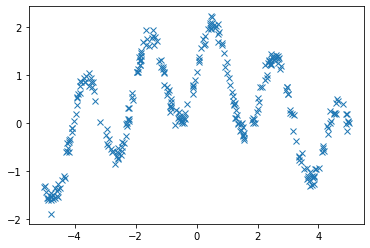

In [2]:
pX = np.linspace(-10.0, 10.0, 300)[:, None]
X = np.random.uniform(-5, 5, 300)[:, None]
Y = np.sin(3 * X) + 0.1  +  np.cos(0.5 * X) + np.random.randn(*X.shape) * 0.1
Z = np.linspace(-5, 5, 50)[:, None]

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

plt.plot(X,Y ,"x")

In [3]:
from gpflow.covariances.dispatch import Kuf, Kuu
from gpflow.kernels import SquaredExponential
from gpflow.utilities.ops import square_distance

class GaussianNoiseInvariant(SquaredExponential):
    def __init__(self, base_variance=1.0, base_lengthscales=1.0, orbit_variance=1.0):
        self.base_variance = gpflow.Parameter(base_variance, transform=gpflow.utilities.bijectors.positive())
        self.base_lengthscales = gpflow.Parameter(base_lengthscales, transform=gpflow.utilities.bijectors.positive())
        self.orbit_variance = orbit_variance
        super().__init__()

    @property
    def lengthscales(self):
        return (self.base_lengthscales ** 2.0 + 2 * self.orbit_variance) ** 0.5

    @lengthscales.setter
    def lengthscales(self, x):
        pass

    @property
    def variance(self):
        return (self.base_lengthscales ** 2.0 / self.lengthscales ** 2.0) ** 0.5 * self.base_variance

    @variance.setter
    def variance(self, x):
        pass


class GaussianNoiseInvariantInducing(gpflow.inducing_variables.InducingPoints):
    pass


@Kuu.register(GaussianNoiseInvariantInducing, GaussianNoiseInvariant)
def Kuu_temp(inducing_variable, kernel, *, jitter=0.0):
    X_scaled = inducing_variable.Z / kernel.base_lengthscales
    r2 = square_distance(X_scaled, None)
    return kernel.base_variance * tf.exp(-0.5 * r2) + jitter * tf.eye(len(inducing_variable), dtype=r2.dtype)


@Kuf.register(GaussianNoiseInvariantInducing, GaussianNoiseInvariant, object)
def Kuf_temp(inducing_variable, kernel, Xnew):
    ls = (kernel.base_lengthscales ** 2.0 + kernel.orbit_variance) ** 0.5
    X_scaled = Xnew / ls
    Z_scaled = inducing_variable.Z / ls
    r2 = square_distance(Z_scaled, X_scaled)
    return kernel.base_variance * (kernel.base_lengthscales ** 2.0 / ls ** 2.0) ** 0.5 * tf.exp(-0.5 * r2)

In [4]:
orbit_variance = 0.1

det_k = GaussianNoiseInvariant(orbit_variance=orbit_variance)

In [5]:
SVGPmodel = SVGP(det_k, likelihood = gpflow.likelihoods.Gaussian(), inducing_variable=GaussianNoiseInvariantInducing(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = SVGPmodel.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGPmodel.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

SVGPelbo = SVGPmodel.elbo((X,Y))

Step: 0, Mini batch elbo: -546.7457032743508
Step: 50, Mini batch elbo: -366.1667261876989
Step: 100, Mini batch elbo: -319.90321155420037
Step: 150, Mini batch elbo: -186.3576639753307
Step: 200, Mini batch elbo: -75.16483983345785
Step: 250, Mini batch elbo: 14.869609010265073
Step: 300, Mini batch elbo: 86.78500766312794
Step: 350, Mini batch elbo: 138.0086104679146
Step: 400, Mini batch elbo: 167.31657303044943
Step: 450, Mini batch elbo: 180.4040530783484
Step: 500, Mini batch elbo: 183.53103623770866
Step: 550, Mini batch elbo: 184.09517385091567
Step: 600, Mini batch elbo: 184.9194399986283
Step: 650, Mini batch elbo: 185.0728561156284
Step: 700, Mini batch elbo: 185.69824574414295
Step: 750, Mini batch elbo: 185.4461458152093
Step: 800, Mini batch elbo: 186.11369546279911
Step: 850, Mini batch elbo: 185.70059846742046
Step: 900, Mini batch elbo: 185.7494566029742
Step: 950, Mini batch elbo: 186.28441191629383
Step: 1000, Mini batch elbo: 185.68551540198723
Step: 1050, Mini batc

In [6]:
orbit_samples = [20, 40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
g_samples = 10
elbo_means = []
elbo_sds = []

for os in orbit_samples:
    stoch_k = invgp.kernels.StochasticInvariant(
        basekern=gpflow.kernels.SquaredExponential(variance = det_k.base_variance, lengthscales = det_k.base_lengthscales),
        orbit=orbits.GaussianNoiseOrbit(variance=orbit_variance,
                                  minibatch_size = os))

    sample_model = SampleSVGP(stoch_k,
                              inducing_variable = StochasticConvolvedInducingPoints(SVGPmodel.inducing_variable.Z), 
                              num_data = len(X),
                              likelihood = gpflow.likelihoods.Gaussian(variance = SVGPmodel.likelihood.variance),
                              q_mu = SVGPmodel.q_mu.numpy(),
                              q_sqrt = SVGPmodel.q_sqrt.numpy(),
                              matheron_sampler = True, num_samples = g_samples)
    container = []
    for it in range(20):
        elbo = sample_model.elbo((X,Y))
        container.append(elbo.numpy())
    elbo_means.append(np.mean(container))
    elbo_sds.append(np.std(container))

In [7]:
elbo_means

[-336.5831323259518,
 -59.606285609291,
 18.841893397095987,
 55.520017799551944,
 82.42764327858445,
 136.54043004437955,
 154.19742424492625,
 162.31453714686714,
 168.0085375056266,
 169.13351565615815,
 171.34359700018734,
 174.0203921200678,
 175.56150690698263,
 176.49169049223062]

<ErrorbarContainer object of 3 artists>

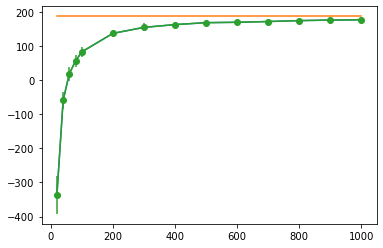

In [8]:
fig, ax = plt.subplots()
plt.plot(orbit_samples, elbo_means, "-")
plt.plot(orbit_samples, SVGPelbo.numpy() * np.ones(len(orbit_samples)))
ax.errorbar(orbit_samples, elbo_means,
            yerr=elbo_sds,
            fmt='-o')

I should somehow visualise the variation of the ELBO in this plot. Should also investigate the impact of g_samples.

## Non-Gaussian likelihood

I tried for the softmax, but there is some bug that I could not immediately solve. So I ran for the Bernoulli.

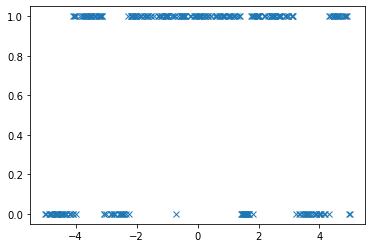

In [9]:
pX = np.linspace(-10.0, 10.0, 300)[:, None]
X = np.random.uniform(-5, 5, 300)[:, None]
Y = np.sin(3 * X) + 0.1  +  np.cos(0.5 * X) + np.random.randn(*X.shape) * 0.1
Y = (Y > 0).astype(int)
#Y = np.sign(Y).astype(int)
Z = np.linspace(-5, 5, 50)[:, None]

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

plt.plot(X,Y ,"x")

In [10]:
orbit_variance = 0.1

det_k = GaussianNoiseInvariant(orbit_variance=orbit_variance)

In [11]:
SVGPmodel = SVGP(det_k, likelihood = gpflow.likelihoods.Softmax(num_classes = 2), 
                 num_data = len(X),
                 num_latent_gps = 2,
                 inducing_variable=GaussianNoiseInvariantInducing(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = SVGPmodel.training_loss_closure(train_iter, compile=False) # Compile not working for softmax-likelihood
optimizer = tf.keras.optimizers.Adam(0.01)
#@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGPmodel.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

SVGPelbo = SVGPmodel.elbo((X,Y))

Step: 0, Mini batch elbo: -256.22839872722795
Step: 50, Mini batch elbo: -162.19570283932345
Step: 100, Mini batch elbo: -125.92755987298767
Step: 150, Mini batch elbo: -105.98206159205958
Step: 200, Mini batch elbo: -100.10155744072594
Step: 250, Mini batch elbo: -97.37971743312542
Step: 300, Mini batch elbo: -98.05524850439397
Step: 350, Mini batch elbo: -94.0387759098624
Step: 400, Mini batch elbo: -92.37578452778132
Step: 450, Mini batch elbo: -90.98411058715944
Step: 500, Mini batch elbo: -90.17768983846099
Step: 550, Mini batch elbo: -89.4019613523005
Step: 600, Mini batch elbo: -88.20790385732573
Step: 650, Mini batch elbo: -88.06294642377156
Step: 700, Mini batch elbo: -87.04968394256332
Step: 750, Mini batch elbo: -87.0829121509795
Step: 800, Mini batch elbo: -86.43056120950061
Step: 850, Mini batch elbo: -85.42493771075397
Step: 900, Mini batch elbo: -84.69478178753539
Step: 950, Mini batch elbo: -84.99176728314428
Step: 1000, Mini batch elbo: -84.55845655153654
Step: 1050, M

In [15]:
orbit_samples = [20, 40, 60, 80, 100, 200, 300]
g_samples = 10
elbo_means = []
elbo_sds = []

for os in orbit_samples:
    stoch_k = invgp.kernels.StochasticInvariant(
        basekern=gpflow.kernels.SquaredExponential(variance = det_k.base_variance, lengthscales = det_k.base_lengthscales),
        orbit=orbits.GaussianNoiseOrbit(variance=orbit_variance,
                                  minibatch_size = os))

    sample_model = SampleSVGP(stoch_k,
                              inducing_variable = StochasticConvolvedInducingPoints(SVGPmodel.inducing_variable.Z), 
                              num_data = len(X),
                              likelihood = SampleSoftmax(num_classes = 2),
                              num_latent_gps = 2,
                              q_mu = SVGPmodel.q_mu.numpy(),
                              q_sqrt = SVGPmodel.q_sqrt.numpy(),
                              matheron_sampler = True, num_samples = g_samples)
    container = []
    for it in range(20):
        elbo = sample_model.elbo((X,Y))
        container.append(elbo.numpy())
    elbo_means.append(np.mean(container))
    elbo_sds.append(np.std(container))

In [16]:
elbo_means

[-92.73404487051155,
 -86.04624358987492,
 -83.80568825413522,
 -83.79611733051784,
 -81.49055563098668,
 -80.51451555109398,
 -80.56555387491989]

<ErrorbarContainer object of 3 artists>

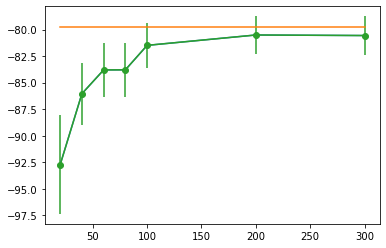

In [17]:
fig, ax = plt.subplots()
plt.plot(orbit_samples, elbo_means, "-")
plt.plot(orbit_samples, SVGPelbo.numpy() * np.ones(len(orbit_samples)))
ax.errorbar(orbit_samples, elbo_means,
            yerr=elbo_sds,
            fmt='-o')